## Dimensionality Reduction and Model Comparison

In this notebook, I reduce the 768-dimensional DeBERTa embeddings using PCA to improve computational efficiency and mitigate overfitting. Subsequently, I compare multiple classification algorithms to establish a robust baseline.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
train_emb = np.load("data/train_embeddings.npy")
test_emb = np.load("data/test_embeddings.npy")

In [4]:
train_df = pd.DataFrame(train_emb, columns=[f"emb_{i}" for i in range(train_emb.shape[1])])
test_df = pd.DataFrame(test_emb, columns=[f"emb_{i}" for i in range(test_emb.shape[1])])
train_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,0.105416,0.229255,0.032642,-0.067727,0.051010,-0.122849,0.020267,0.140387,-0.203620,0.032540,...,-0.104533,0.107250,-0.001299,0.064792,-0.013607,-0.052724,0.063353,-0.013496,0.193849,0.025834
1,0.097687,0.219986,0.058977,-0.084044,0.090142,-0.125159,-0.003105,0.114609,-0.197948,0.052772,...,-0.099950,0.081551,-0.049584,0.070057,-0.029232,-0.139531,0.015191,-0.054459,0.172969,-0.007371
2,0.139302,0.209250,0.051078,-0.071902,0.072903,-0.123652,0.011826,0.100010,-0.191934,0.066873,...,-0.121393,0.039200,-0.031125,0.041774,-0.000281,-0.116240,0.009761,-0.066319,0.165006,0.043972
3,0.147291,0.221638,0.029100,-0.075694,0.081218,-0.127636,0.022426,0.129949,-0.196388,0.061044,...,-0.101378,0.072086,-0.029069,0.031978,-0.007993,-0.131807,0.033268,-0.089738,0.172987,0.021650
4,0.142027,0.199940,0.022030,-0.064067,0.074370,-0.122768,0.008187,0.125156,-0.209924,0.063767,...,-0.101361,0.071649,-0.034237,0.011667,0.004223,-0.111813,0.009486,-0.042143,0.157490,0.027697


### Model Comparison before PCA

Before applying dimensionality reduction, I conduct an initial comparison across various algorithms.

To understand how different models handle the raw 768-dimensional DeBERTa embeddings. This serves as a baseline to evaluate whether PCA-reduced features maintain, improve, or degrade the predictive performance.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_df, df_train["target"], test_size=0.3, random_state=42)

In [7]:
models = {
    "Logistic": LogisticRegression(random_state=42),
    "knn": KNeighborsClassifier(),
    "svm": SVC(random_state=42),
    "randomforest": RandomForestClassifier(),
    "xgb": XGBClassifier(random_state=42),
    "lgb": LGBMClassifier(random_state=42)
}

In [8]:
result = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    result[name] = {"train": train_score, "test": test_score}

result = pd.DataFrame(result)
result

/opt/anaconda3/envs/kaggle-ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 2305, number of negative: 3024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5329, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432539 -> initscore=-0.271500
[LightGBM] [Info] Start training from score -0.271500


,Logistic,knn,svm,randomforest,xgb,lgb
train,0.764121,0.785513,0.567461,0.997936,0.997936,0.996059
test,0.764011,0.676007,0.577058,0.750876,0.771891,0.764448


By using raw embedding dataset, I obtained the result above.

What I observerd, boosting model and tree-based model are highly likely to overfit. While they achieve near-perfect accuracy on the training set, their performance on the test set is significantly lower.

In this specific situation, Logistic Regression model is the best classifier for prediction. It maintains a very small gab between training and testing accuracy.

Next, let's see how the the results change after applying PCA.

### Dimensionality Reduction via PCA

Preserve maximum information while reducing the feature space.

High-dimensional data (768dim) often contains redundancy and noise.

Standardization: Before applying PCA, the features are scaled to have mean=0 and variance=1 to ensure each dimension contributes equally.

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

pca = PCA()
train_pca = pca.fit_transform(train_scaled)

cum_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cum_ratio >=0.90) + 1

print(n_components)

81


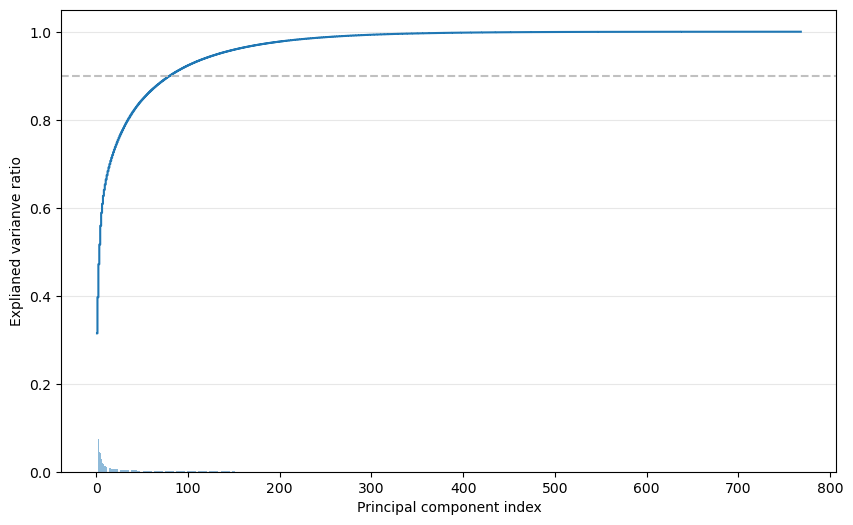

In [10]:
import matplotlib.pyplot as plt
evr =pca.explained_variance_ratio_
cum_evr = np.cumsum(evr)

plt.figure(figsize=(10,6))
plt.bar(range(1, len(evr)+1), evr, alpha=0.5, align="center")
plt.step(range(1, len(evr)+1), cum_evr, where="mid")
plt.axhline(y=0.90, color='silver', linestyle='--')
plt.ylabel("Explianed varianve ratio")
plt.xlabel("Principal component index")
plt.grid(axis='y', alpha=0.3)

By keeping 81 components, we retain approximately 90% of the total variance. This confirms that the embedding space can be significantly compressed without losing critical semantic information.

In [11]:
train_pca_df = pd.DataFrame(train_pca[:,:n_components], columns=[f"pca_{i}" for i in range(n_components)])
test_pca_df = pd.DataFrame(pca.transform(test_scaled)[:,:n_components], columns=[f"pca_{i}" for i in range(n_components)])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_pca_df, df_train["target"], test_size=0.3, random_state=42)
result = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    result[name] = {"train": train_score, "test": test_score}

result = pd.DataFrame(result)
result

[LightGBM] [Info] Number of positive: 2305, number of negative: 3024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20655
[LightGBM] [Info] Number of data points in the train set: 5329, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432539 -> initscore=-0.271500
[LightGBM] [Info] Start training from score -0.271500


,Logistic,knn,svm,randomforest,xgb,lgb
train,0.767311,0.785889,0.828861,0.998123,0.998123,0.984237
test,0.765762,0.692207,0.781086,0.742557,0.750876,0.765324


What I observed

- **Overfitting in Tree-based Models** : Random Forest and XGBoost still showed nearly 100% accuracy on the training set but lower scores on the test set, indicating a high risk of overfitting even after PCA.

- **Efficiency of Linear Models**: Logistic Regression and SVM performed competitively with the boosting models while maintaining a smaller gap between train/test scores, suggesting better generalization.



### Final Model

By comparing the results before and after applying PCA, I have reached the following conclusions.

- **SVM** Both training and testing score siginificantly improved after PCA.  

- **Logistic Regression** While it maintained a high and stable accuracy score, it did not show the same level of performance gain as SVM after PCA.

Thus, I decide to employ the SVM model for fianl submission. 

In [13]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
print(svc.score(X_test,y_test))
pred = svc.predict(test_pca_df)

0.7810858143607706


In [14]:
submit = pd.read_csv("data/sample_submission.csv")
submit['target'] = pred

In [15]:
submit.to_csv('submit_folder/pca_svc_result.csv', index=False)